# KBO 타자 OPS 예측
- 우승 비결 : 
    - 도메인 지식에 데이터 분석 지식을 결합한 것
    - 가능한 단순한 모델을 제안 : 데이터 수는 적지만 feature가 많이 존재, 과적합을 피하기 위해 단순화한 정보들로 머신러닝 모델 진행

## 1. 문제 정의
### 1-1. 대회 소개
- 문제 : 데이터를 바탕으로 2019년도 타자들의 상반기 OPS 예측
- 문제 유형 : Time-Series, Regression
- 평가 척도 : WRMSE
- 데이터 기간 : 2010년부터 2018년까지
- 데이터 수집 기준 : 1군 엔트리에 1번 이상 포함되었던 타자들의 역대 정규시즌, 시범경기 성적 정보

### 1-2. 평가 척도
- WRMSE : (((i번째 선수 실제값 - i번째 선수 예측값)*i번째 선수 가중치)/모든 가중치의 합)의 합, sigma(sqrt((yi-yhati)^2 * wi/sigma(wi)))
- 오차가 작을수록 우수한 성능을 보임
- 가중치 : 타수 기준, 타수가 없는 선수는 가중치 0
- 경기를 많이 뛰는 선수를 잘 예측할 수록 WRMSE를 낮추는데 좋음

### 1-3. 도메인 조사
- 정규시즌 : 프로 스포츠 경기
- 시범경기 : 정규시즌 시작 전에 열리는 비공식 경기
- 상반기의 기준 : 2019년은 7월 18일까지로 따짐
- OPS : On base Plus Slugging, 타자들의 종합 성적 기준, OBP(출루율)+SLG(장타율)

### 1-4. 문제 해결을 위한 접근 방식
- 데이터 수(행)에 비해 설명 변수(열)이 많음 -> 가능한 한 단순한 모델을 만들어 예측, 필요없는 데이터 삭제
- 분석 순서 : 데이터 탐색 -> 분석 전략 수립, 데이터 전처리 -> 모델링 -> 추가적인 성능 향상 방법

## 2. 탐색적 데이터 분석

In [2]:
# import library
import numpy as np
import pandas as pd
import matplotlib as mlt
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
import sklearn
import platform

In [3]:
# 한글 폰트 사용
if platform.system() == 'Windows' :
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font',family=font_name)
else :
    rc('font', family = 'AppleGothic')

# 그래프에서 -기호 사용
mlt.rcParams['axes.unicode_minus'] = False

In [27]:
# Data 불러오기
Pre = pd.read_csv(r'./data/Pre_Season_batter.csv')
Reg = pd.read_csv(r'./data/Regular_Season_Batter.csv')


|변수| 설명|
|-|-|
|batter_id        |타자 고유번호|
|batter_name      |타자 이름|  
|year             |년도|  
|team             |소속 팀|  
|avg              |타율(batting Average), 타수 대비 안타 비율|  
|G                |출전 게임 수|  
|AB               |타수(At Bat), 타자가 정규로 타격을 완료한 횟수|  
|R                |득점|  
|H                |안타|  
|2B               |2루타|  
|3B               |3루타|  
|HR               |홈런|  
|TB               |루타 수|  
|RBI              |타점|  
|SB               |도루 성공|  
|CS               |도루 실패|  
|BB               |볼넷(Base on balls), 볼을 네 번 얻어 출루한 경우|  
|HBP              |사구(Hit By Pitch),투수가 던진 공이 타자에 맞아 출루한 경우|  
|SO               |삼진 아웃|  
|GDP              |병살타|  
|SLG              |장타율(Slugging Percentage), 타수에서 기대되는 평균 루타|  
|OBP              |출루율(On Base Percentage), 타수 대비 아웃되지 않고 1루로 출루한 비율|  
|E                |에러|  
|height/weight    |키/몸무게|  
|year_born        |생년월일|  
|position         |경기 위치|  
|career           |졸업학교|  
|starting_salary  |시작 연봉|  
|OPS              |출루율(On Base Percentage), 타수 대비 아웃되지 않고 1루로 출루한 비율)|  

### 1.2.1 프리시즌 데이터 분석

In [19]:
# Data 확인
display(Pre.head(10))
print(Pre.shape)

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
0,0,가르시아,2018,LG,0.350,7,20,1,7,1,...,1,0.550,0.409,1,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.959
1,1,강경학,2011,한화,0.000,4,2,2,0,0,...,0,0.000,0.500,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.500
2,1,강경학,2014,한화,-,4,0,2,0,0,...,0,NaN,NaN,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,NaN
3,1,강경학,2015,한화,0.130,10,23,3,3,0,...,0,0.130,0.286,2,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.416
4,1,강경학,2016,한화,0.188,14,32,4,6,1,...,0,0.281,0.212,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.493
5,1,강경학,2017,한화,0.222,11,36,10,8,0,...,0,0.389,0.282,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.671
6,2,강구성,2013,NC,0.000,3,4,0,0,0,...,1,0.000,0.000,0,180cm/82kg,1993년 06월 09일,외야수(우투좌타),관산초-부천중-야탑고-NC-상무,9000만원,0.000
7,2,강구성,2016,NC,0.000,3,1,0,0,0,...,1,0.000,0.500,0,180cm/82kg,1993년 06월 09일,외야수(우투좌타),관산초-부천중-야탑고-NC-상무,9000만원,0.500
8,2,강구성,2017,NC,1.000,2,1,0,1,0,...,0,1.000,1.000,0,180cm/82kg,1993년 06월 09일,외야수(우투좌타),관산초-부천중-야탑고-NC-상무,9000만원,2.000
9,69,김태완,2006,한화,0.200,10,15,0,3,0,...,1,0.200,0.278,0,189cm/105kg,1984년 01월 27일,내야수(우투우타),양목초-신월중-중앙고-성균관대-한화,11000만원,0.478


(1393, 29)


In [22]:
# Data 결측 확인
Pre.isna().sum()

batter_id            0
batter_name          0
year                 0
team                 0
avg                  0
G                    0
AB                   0
R                    0
H                    0
2B                   0
3B                   0
HR                   0
TB                   0
RBI                  0
SB                   0
CS                   0
BB                   0
HBP                  0
SO                   0
GDP                  0
SLG                 29
OBP                 25
E                    0
height/weight        0
year_born            0
position             0
career               0
starting_salary    214
OPS                 29
dtype: int64

In [14]:
# Data 기초통계량
Pre.describe()

,batter_id,year,G,AB,R,H,2B,3B,HR,TB,...,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,OPS
count,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,...,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1364.000000,1368.000000,1393.000000,1364.000000
mean,173.434314,2013.014358,8.705671,19.201723,2.679828,5.021536,0.954774,0.119885,0.391960,7.391960,...,0.629576,0.291457,1.877961,0.330223,3.714286,0.447236,0.361012,0.317912,0.381910,0.676924
std,94.716851,4.166757,5.562686,13.395946,2.637212,4.232584,1.196904,0.379976,0.748557,6.538787,...,1.146854,0.595522,2.053392,0.642204,3.180884,0.723364,0.269892,0.151489,0.729521,0.386933
min,0.000000,2002.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,99.000000,2010.000000,6.000000,9.000000,1.000000,2.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.217000,0.250000,0.000000,0.472000
50%,178.000000,2014.000000,9.000000,18.000000,2.000000,4.000000,1.000000,0.000000,0.000000,6.000000,...,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.344500,0.333000,0.000000,0.675000
75%,254.000000,2017.000000,11.000000,28.000000,4.000000,8.000000,2.000000,0.000000,1.000000,11.000000,...,1.000000,0.000000,3.000000,1.000000,5.000000,1.000000,0.478000,0.400000,1.000000,0.867000
max,344.000000,2018.000000,119.000000,183.000000,35.000000,51.000000,11.000000,4.000000,5.000000,68.000000,...,9.000000,4.000000,21.000000,4.000000,36.000000,5.000000,4.000000,1.000000,5.000000,5.000000


- 행 1393, 열 29
- 결측 있음
- 년도 범위 2002-2018

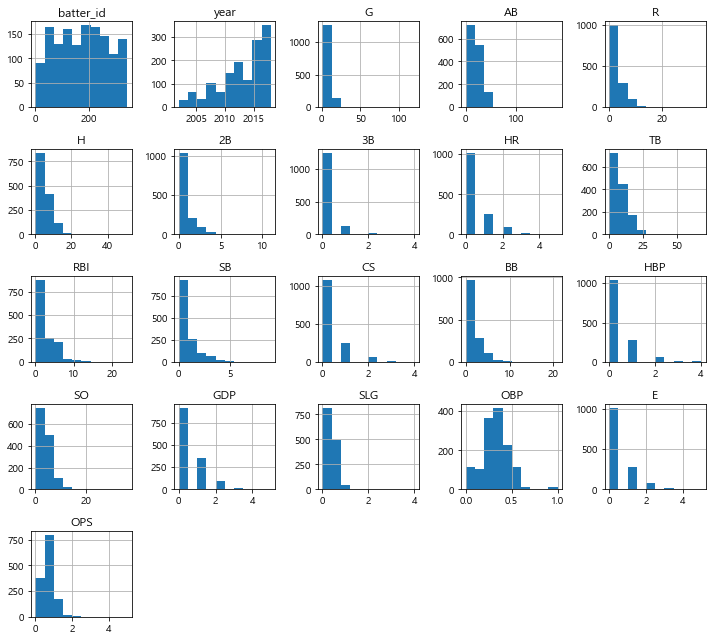

In [26]:
# Data 시각화
Pre.hist(figsize=(10,9))
plt.tight_layout()
plt.show()

- G, AB, R, H, 2B, 3B, HR, TB, RBI, SB, CS, BB, HBP, SO, GDP, SLG, E, OPS 가 0에 가까운 값을 가짐
- 년도는 최근 것이 가장 많이 측정 됨 (과거의 정보 부족) => 정규시즌과 비교하며 확인
- OBP가 제일 정규분포에 가까움

### 1.2.2 프리시즌과 정규시즌 데이터 분석

In [32]:
# 프리시즌과 정규시즌 년도별 비교
Pre_cnt = Pre.groupby('year')['batter_id'].count().rename('Pre')
Reg_cnt = Reg.groupby('year')['batter_id'].count().rename('Reg')
pd.concat([Pre_cnt,Reg_cnt,round(Pre_cnt/Reg_cnt,2).rename('ratio')],axis=1).transpose().loc[:,2002:]

year,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Pre,12.00,19.00,28.00,37.00,36.00,43.00,61.00,66.00,72.00,75.0,87.0,104.00,117.00,134.00,153.00,167.00,182.0
Reg,43.00,54.00,68.00,73.00,85.00,98.00,115.00,124.00,130.00,151.0,174.0,194.00,186.00,207.00,213.00,217.00,227.0
ratio,0.28,0.35,0.41,0.51,0.42,0.44,0.53,0.53,0.55,0.5,0.5,0.54,0.63,0.65,0.72,0.77,0.8


- 2002년 이전은 프리시즌 데이터가 없어서 제거
- 최근으로 올수록 정규시즌 대비 프리시즌 비율이 올라감

In [43]:
# 타자 이름과 년도로 new_idx 생성(년도로 가능할까? 생년월일이 아니고?)
Pre['new_idx'] = Pre['batter_name'] + Pre['year'].apply(str)
Reg['new_idx'] = Reg['batter_name'] + Reg['year'].apply(str)

# 새로운 인덱스의 교집합
inter_idx = list(set(Reg['new_idx']).intersection(Pre['new_idx']))

# 교집합에 존재하는 데이터만 불러오기
N_Reg = Reg.loc[Reg['new_idx'].apply(lambda x : x in inter_idx)].copy()
N_Reg = N_Reg.sort_values(by='new_idx').reset_index(drop=True) #왜 하는거지?

# 비교를 위해 인덱스로 정렬
N_Pre = Pre.loc[Pre['new_idx'].apply(lambda x : x in inter_idx)].copy()
N_Pre = N_Pre.sort_values(by='new_idx').reset_index(drop=True)

# 검정 코드
print(N_Reg.shape, N_Pre.shape)
sum(N_Reg['new_idx']==N_Pre['new_idx'])

(1358, 30) (1358, 30)


1358

C:\Users\user\Appdata\Roaming\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


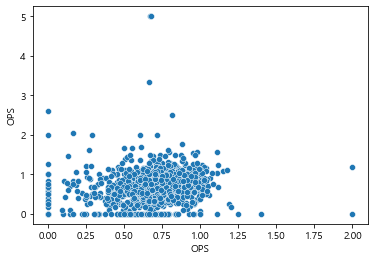

In [50]:
# 정규시즌과 프리시즌의 상관관계 계산
corr_PR = N_Reg['OPS'].corr(N_Pre['OPS'])
sns.scatterplot(N_Reg['OPS'], N_Pre['OPS'])
plt.title('Pre-Reg 상관계수 :' + str(round(corr_PR,2)), fontsize=20)
plt.xlabel("정규시즌 OPS", fontsize=12)
plt.ylabel("프리시즌 OPS", fontsize=12)
plt.show()

- 정규시즌과 프리시즌의 OPS는 연관성이 적음 => 2019의 정규시즌 상반기 예측이기에 프리시즌 데이터는 필요없다고 판단, 제거